**WARNING**: Remember to run the `ExtractBoundaries` notebook present in step2b folder before running all (or specifically the `Import Boundaries` cell)

**WARNING2**: You should also run `Generate Class Masks` from step 4b

In [ ]:
SAVE_ON_DRIVE = True # Set to True if you want to save the datasets and trained models to your Google Drive
TYPE = 'Train'

# Dataset initialization


### Download Data

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

# Set paths for Validation and Test datasets
val_dataset_path = '/content/drive/MyDrive/LoveDA/Val'
test_dataset_path = '/content/drive/MyDrive/LoveDA/Test'


# Function to handle dataset download and extraction
def handle_dataset(dataset_name, zip_url, local_path, drive_path):
    if not os.path.exists(local_path):
        if os.path.exists(f"{drive_path}.zip"):
            print(f"{dataset_name} dataset available on own drive, unzipping...")
            !unzip -q {drive_path}.zip -d ./
        else:
            print(f"Downloading {dataset_name} dataset...")
            !wget -O {dataset_name}.zip "{zip_url}"
            if SAVE_ON_DRIVE:
                print(f"Saving {dataset_name} dataset on drive...")
                !cp {dataset_name}.zip {drive_path}.zip
                print(f"{dataset_name} dataset saved on drive")
            print(f"Unzipping {dataset_name} dataset...")
            !unzip -q {dataset_name}.zip -d ./
    else:
        print(f"{dataset_name} dataset already in local")

# Handle Validation dataset
# handle_dataset("Validation", "https://zenodo.org/records/5706578/files/Val.zip?download=1", "./Val", "/content/drive/MyDrive/LoveDA/Val")

# Handle Test dataset
#handle_dataset("Test", "https://zenodo.org/records/5706578/files/Test.zip?download=1", "./Test", "/content/drive/MyDrive/LoveDA/Test")

# Handle Train dataset
handle_dataset("Train", "https://zenodo.org/records/5706578/files/Train.zip?download=1", "./Train", "/content/drive/MyDrive/LoveDA/Train")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset already in local


### Import Boundaries

In [ ]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

# if (rural_file_count != rural_mask_file_count):
#     print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
#     shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
# else:
#     print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

./Train/Rural/boundaries_png exists...
./Train/Urban/boundaries_png exists...
Urban boundaries already present, 1156 files...


### Import MixMasks

In [ ]:
mixmasks_source_path = '/content/drive/MyDrive/LoveDA/MixMasks.zip'
mixmasks_destination_path = './Train/Urban/MixMasks'

if not os.path.exists(mixmasks_destination_path):
    os.makedirs(mixmasks_destination_path)

if not (len(os.listdir('./Train/Urban/masks_png')) == len(os.listdir('./MixMasks'))):
    print(f"Not all MixMasks present, importing...")
    shutil.copy(mixmasks_source_path, './MixMasks.zip')
else:
    print(f"MixMasks already present")

FileNotFoundError: [Errno 2] No such file or directory: './MixMasks'

### Dataset Definition

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
import cv2


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, baseTransform, augTransforms, split = 'Urban', type = 'Train', useBoundaries=True, validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation', 'Total', 'ActualTest']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest'.")
        self.directory = []
        if type == 'ActualTest':
            directory_path = os.path.join('./Test', split, 'images_png')
        else:
            directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        elif type == 'Total':
            self.directory = all_images
        elif type == 'ActualTest':
            self.directory = all_images
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest.")
        self.baseTransforms = baseTransform
        self.augTransforms = augTransforms
        self.useBoundaries = useBoundaries
        self.typeDataset = type
        # Print dataset size
        print(f"Dataset size: {len(self.directory)}")

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')
        boundaries_path = image_path.replace('images_png', 'boundaries_png')

        mask = pil_loader(mask_path, 'L')

        if self.useBoundaries:
          boundaries = pil_loader(boundaries_path, 'L')
        else:
          boundaries = mask

        base_transformed = self.baseTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        base_image = base_transformed['image']
        base_mask = base_transformed['mask']
        base_boundaries = base_transformed['boundaries']

        base_image = T.Compose([T.ToTensor()])(base_image)
        base_mask = torch.from_numpy(base_mask).long()
        base_mask -= 1
        base_boundaries = torch.from_numpy(base_boundaries)

        if(self.typeDataset != 'Train'):
          return base_image, base_mask, image_path, base_boundaries


        if self.augTransforms == None:
          return [base_image], [base_mask], image_path, [base_boundaries]
        # Apply transformations
        augmented = self.augTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        augmented_image = T.Compose([T.ToTensor()])(augmented['image'])

        mask = augmented['mask']
        mask = torch.from_numpy(mask).long()
        mask = mask-1
        boundaries = augmented['boundaries']
        boundaries = torch.from_numpy(boundaries)

        image_list = [base_image, augmented_image]
        mask_list = [base_mask, mask]
        boundaries_list = [base_boundaries, boundaries]

        return image_list, mask_list, image_path, boundaries_list

### Dataset Utils

In [ ]:
import matplotlib.patches as mpatches

from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



### Dataset Debug

In [ ]:
# # Comment this cell to save GPU time

# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.patches as mpatches

# train_dataset = LoveDADataset(type='Train', seed=222)
# print(train_dataset.__len__())

# # Get item
# image, mask, path, bd = train_dataset.__getitem__(88)

# # Show path
# print(f"Image is at {path}")

# # Show image
# image = image.permute(1, 2, 0)
# image = image.numpy()
# plt.imshow(image)

# # Show mask
# new_image = new_colors_mask(mask)
# plt.imshow(image)
# plt.show()
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.imshow(new_image)
# plt.show()

# # Show boundaries
# # for row in bd:
# #     for col in row:
# #         if col != 0 and col != 1:
# #             print(col)
# bd = bd.numpy()
# plt.imshow(bd)


# Initialize model

### PIDNet Util Modules

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)



### PIDNet Definition

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

INPUT_SIZE = (512, 512)

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        h, w = x.size(2), x.size(3)

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

In [ ]:
# Remember to upsample the input x before running it through this, as the paper says
import torch
import torch.nn as nn
import torch.nn.init as init


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Conv2d(num_classes, 64, kernel_size=4, stride=2, padding=1),  # Conv1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Conv2
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Conv3
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Conv4
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # Conv5
        )

    def forward(self, x):
        return self.domain_classifier(x)

# Initialize the model with Kaiming initialization
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

### Load PIDNet Model

In [ ]:
import gdown
import tarfile

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# Create a config object with required parameters
class Config:
    class MODEL:
        NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
        PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
    class DATASET:
        NUM_CLASSES = len(LABEL_MAP)

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
# model = get_pred_model('s', len(LABEL_MAP))


<ipython-input-72-c45f6e9ccf7a>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


# Training & Dataset creation

### Ablations and Macros

In [ ]:
DEVICE = 'cpu' # 'cuda' or 'cpu'

LR = 8*1e-4            # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size:: new_LR = old_LR * sqrt(batch_size_new / batch_size_old)
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 14       # How many epochs before decreasing learning rate (if using a step-down policy) -- Trying to keep a 2:3 ratio with NUM_EPOCHS
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 70
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 2 ####### WARNING: LEAVE TO TWO IF YOU WANT TO FOLLOW THE DACS REPO STEP BY STEP CIRCA

TARGET_TRANSFORMS = 'None' # 'weak' 'strong' or 'None'
LAMBDA_MIXED = 1

SAVE_AFTER_EPOCH = 16

### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, Rotate, Resize, OneOf, Normalize, ColorJitter, GaussianBlur
from albumentations.pytorch import ToTensorV2

#How big should be the image that we feed to the model?
RESIZE = 512
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem


AUGMENTATIONS = {
    'Resize512': Compose([
            Resize(512, 512),
    ], additional_targets={"boundaries": "mask"}),
    'Normalize': Compose([
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop256': Compose([
            RandomCrop(256, 256),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop512': Compose([
            RandomCrop(512, 512),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCrop512+Normalization' : Compose([
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True),
            RandomCrop(512, 512),
            ], additional_targets={"boundaries": "mask"}),
    'RandomCropOrResize': Compose([
            OneOf([
                RandomCrop(RESIZE, RESIZE, p=0.5),  # Random crop to resize
                Resize(RESIZE, RESIZE, p=0.5)
            ], p=1)
            ], additional_targets={"boundaries": "mask"}),
    'RandomCropXXX': Compose([
            OneOf([
                RandomCrop(256, 256),  # Random crop to resize
                RandomCrop(512, 512),
            ], p=1)
            ], additional_targets={"boundaries": "mask"}),
    'Jitter': Compose([
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'NormalizeOnRural': Compose([
            Normalize(mean=(73.532, 80.017, 74.593), std=(41.493, 35.653, 33.747), max_pixel_value=1.0, always_apply=True),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
    'GaussianBlur': Compose([
            GaussianBlur(p=0.5),
            Resize(RESIZE, RESIZE),
            ], additional_targets={"boundaries": "mask"}),
}

CHOOSE_TRANSFORM = 'Resize512'
AUGTRANSFORM = None

## Dataset and Loader
# Training Sets and Loaders
source_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Urban', type='Train', validation_ratio=0.2)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

target_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Rural', type='Train', validation_ratio=0.2, useBoundaries=False)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

# Validation Sets and Loaders
source_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Urban', type='Validation', validation_ratio=0.2, useBoundaries=False)
source_validation_loader = DataLoader(source_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

target_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Rural', type='Validation', validation_ratio=0.2, useBoundaries=False)
target_validation_loader = DataLoader(target_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

## Model is defined some cells above, in LoadPidNetModel
drive_path = '/content/drive/MyDrive/LoveDA'
#If you want to UPLOAD an existing model for re-training

LOAD_BASE_MODEL = True
model_name = 'best_model_Resize.pth'
if LOAD_BASE_MODEL:
  #model_path = os.path.join(drive_path, model_name)
  #best_model = torch.load(model_path, map_location=DEVICE)
  best_model = torch.load(f'/content/{model_name}', weights_only=True)
  model.load_state_dict(best_model)

## Optimizier and Scheduler
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Dataset size: 924
Dataset size: 1092
Dataset size: 232
Dataset size: 274


### Losses

In [ ]:
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
def cross_entropy(score, target):
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
    balance_weights = [0.4, 1]
    sb_weights = 1 # WARNING: BY CHANGING THIS WEIGHT YOU'RE ACTUALLY AFFECTING ALSO SOME OTHER PARTS OF THE CODE, see where we use sem_loss

    # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")
    if len(balance_weights) == len(score):
        return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
    elif len(score) == 1:
        return sb_weights * compute_ce_loss(score[0], target)
    else:
        raise ValueError("lengths of prediction and target are not identical!")

sem_loss = cross_entropy
bd_loss = boundary_loss
bce_loss = torch.nn.BCEWithLogitsLoss()

### MixMask Utils

In [ ]:
# extract classes from source masks
def extract_classes_from_mask(mask):
  return torch.unique(mask)

# randomly select classes to mix
def select_classes_for_mix(classes):
    nclasses = classes.shape[0]
    num_classes_to_select = (nclasses + nclasses % 2) // 2  # Take half of the classes (rounded up if odd)
    selected_classes = classes[torch.randint(0, nclasses, (num_classes_to_select,))]
    return selected_classes

# create masks for mixed classes
# generate a mask where only pixels from the selected classes are retained
def generate_class_mask(labels, selected_classes):
    mask = torch.zeros_like(labels)
    for class_id in selected_classes:
        mask[labels == class_id] = 1 # set to 1 where the class is present
    return mask

def apply_augmentations(images, augmentation_type):
    if augmentation_type == 'strong':
        augmentations = T.Compose([
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            T.RandomHorizontalFlip(),
            T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
        ])
    elif augmentation_type == 'weak':
        augmentations = T.Compose([
            T.RandomHorizontalFlip()
        ])
    elif augmentation_type == 'None':
        augmentations = T.Compose([])

    augmented_images = augmentations(images)

    return augmented_images

# data is sth like:     [src_px_1, src_px_2, ..., src_px_-2, src_px_-1]     src keeps with mix_mask==1
#                       [trg_px_1, trg_px_2, ..., trg_px_-2, trg_px_-1]     trg keeps with mix_mask==0
# mix_mask is sth like: [    1   ,     0   , ...,     0    ,     1    ]
def do_mixing(mix_mask, data=None, target=None):
    assert data is not None or target is not None, "Data or target must be provided."

    if mix_mask is not None:
        # Mix the source and target images/masks
        if data is not None:
            data = mix_mask * data[0] + (1 - mix_mask) * data[1]
        if target is not None:
            target = mix_mask * target[0] + (1 - mix_mask) * target[1]

    # # For when I upscale to perform on n batches


    # # Apply strong augmentations to the mixed data
    # if data is not None:
    #     data = apply_augmentations(data, augmentation_type='strong')

    return data, target


# batch_data[0] is sth like:      [...whole_source_batch_images...]     src keeps with mix_mask==1
# batch_data[1]:                  [...whole_target_batch_images...]     trg keeps with mix_mask==0
# mix_masks is sth like:    [    1   ,     0   , ...,     0    ,     1    ]
#                           [    0   ,   ...   , ...,  ...     ,     1    ]
#                           [    1   ,     1   , ...,     1    ,     1    ]
def do_mixing_fullbatch(mix_masks, batch_data=None, batch_target=None):
    assert batch_data is not None or batch_target is not None, "Data or target must be provided."

    if mix_masks is not None:
        if batch_data is not None:
            batch_mixed_data = mix_masks * batch_data[0] + (1 - mix_masks) * batch_data[1]
        if batch_target is not None:
            batch_mixed_target = mix_masks * batch_target[0] + (1 - mix_masks) * batch_target[1]

    return batch_mixed_data, batch_mixed_target

### Training Loop

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
import torch.nn.functional as F

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

SAVE_MODEL_AS = f'best_DACS_model_{CHOOSE_TRANSFORM}__PRETRN={LOAD_BASE_MODEL}__LAMBDA_MIXED={LAMBDA_MIXED}__LR={LR}_LRstep={STEP_SIZE}.pth'
MODEL_NAME = SAVE_MODEL_AS

current_step = 0

best_loss = float('inf')
best_model = model.state_dict()
best_mIoU = 0;

model = model.to(DEVICE)

if TYPE == 'Train':
    print(f"training model {SAVE_MODEL_AS}")
    for epoch in range(NUM_EPOCHS):
        model.train()

        # fill with your losses
        epoch_losses = {
            'loss_complete': 0.0,
            'amount': 0, # amt of images I think?
            'loss_pidnet': 0.0,
            'loss_mixed': 0.0
        }

        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
        srcldr_len = len(source_loader)
        tgtldr_len = len(target_loader)
        print(f"len of source_loader is {srcldr_len}, len of target_loader is {tgtldr_len}. WARNING: make sure source is shorter than target, or modify code to fix early stopping")

        # ================================== Train Epoch X ==================================
        for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_loader, target_loader)), total=len(source_loader)):
            optimizer.zero_grad()

            ### Extract input
            image_list_source, masks_list_source, img_path_source, bd_gts_list_source = batch_s
            image_list_target, _, _, _ = batch_t

            index = 0
            for images, masks, bd_gts, images_t in zip(image_list_source, masks_list_source, bd_gts_list_source, image_list_target):
                ### Extract Images, Masks, Boundaries
                # Source
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                bd_gts = bd_gts.float().to(DEVICE)
                # print(f"DEBUG: source_image batch shape: {images.shape}")
                # print(f"DEBUG: source_mask batch shape: {masks.shape}")

                # Target
                images_t = images_t.to(DEVICE)
                # print(f"DEBUG: target_image batch shape: {images.shape}")


                ### ===> Train Segmentation --- on Source
                ## Forward
                outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                        # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

                ## Upscale (bilinear interpolation - not learned)
                h, w = masks.size(1), masks.size(2)
                ph, pw = outputs[0].size(2), outputs[0].size(3)
                if ph != h or pw != w:
                    for i in range(len(outputs)):
                        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                ## Losses
                # Semantic Losses (l_0 and l_2)
                loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

                # Boundary Loss (l_1)
                loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

                # Boundary AwareneSS (BAS) Loss (l_3)
                filler = torch.ones_like(masks) * -1
                bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                                    # REMEMBER to wrap in list, as the checks in ce use that to know what to do
                loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

                # Segmentation Loss w/o DA (on source domain, which has labels)
                loss_pidnet = loss_s + loss_b + loss_sb  # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
                if batch_i % LOG_FREQUENCY == 0:
                    print(f'\n[losses are unscaled] loss_pidnet at batch {batch_i}: {loss_pidnet.item()}', end=" --- ")
                epoch_losses['loss_pidnet'] += loss_pidnet.item()

                ## Backprop
                loss = loss_pidnet #/ srcldr_len
                epoch_losses['loss_complete'] += loss.item()
                epoch_losses['loss_pidnet'] += loss.item()
                loss.backward()
                ### <=== Train Segmentation --- on Source

                ### ===> Train Segmentation --- on Mixed
                weak_augmented_target = apply_augmentations(images_t, TARGET_TRANSFORMS)

                ## Forward
                outputs_t = model(weak_augmented_target)

                ## Upscale
                h, w = images_t.size(2), images_t.size(3)
                ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)

                ## Create pseudo masks
                pseudo_masks = torch.argmax(output_t, dim=1)  # Get predicted classes

                ## Mix images and masks
                mixed_images, mixed_masks = [], []
                for i in range(images.size(0)):
                    MixMask = generate_class_mask(masks[i], select_classes_for_mix(extract_classes_from_mask(masks[i]))).unsqueeze(0)

                    mixed_img, _ = do_mixing(MixMask, data=torch.cat((images[i].unsqueeze(0), images_t[i].unsqueeze(0)), dim=0))
                    _, mixed_mask = do_mixing(MixMask, target=torch.cat((masks[i].unsqueeze(0), pseudo_masks[i].unsqueeze(0)), dim=0))

                    mixed_images.append(mixed_img.unsqueeze(0))
                    mixed_masks.append(mixed_mask)

                ## Try doing it with batches

                mixed_images = torch.cat(mixed_images)
                mixed_masks = torch.cat(mixed_masks).long()

                outputs_m = model(mixed_images)
                h, w = images_t.size(2), images_t.size(3)
                ph, pw = outputs_m[0].size(2), outputs_t[0].size(3)
                output_m = F.interpolate(outputs_m[-2], size=(h, w), mode='bilinear', align_corners=True)

                                # Careful: sem_loss hardcodes some weights, but the weight for single output loss calculation is 1, thus using it as of now is fine
                loss_mixed = sem_loss([output_m], mixed_masks) * LAMBDA_MIXED
                epoch_losses['loss_complete'] += loss_mixed.item()
                epoch_losses['loss_mixed'] += loss_mixed.item()
                loss_mixed.backward()
                ### <=== Train Segmentation --- on Mixed

                optimizer.step()
                epoch_losses['amount'] += images.size(0)


        # ================================== Validation Main Model ==================================
        # Validate model on the evaluation set and save the parameters if is better than best model
        model.eval()
        # total_loss = 0.0
        # epoch_losses_eval = {
        #     'loss_complete': 0.0,
        #     'amount': 0, # amt of images I think?
        #     'loss_pidnet': 0.0,
        #     'loss_target': 0.0
        # }

        outputs = []
        with torch.no_grad():
            for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_validation_loader, target_validation_loader))):
                ### Extract input
                images, masks, _, bd_gts = batch_s
                images_t, masks_t, _, _ = batch_t

                ### Extract Images, Masks, Boundaries
                # Source
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                bd_gts = bd_gts.float().to(DEVICE)
                # print(f"DEBUG: source_image batch shape: {images.shape}")
                # print(f"DEBUG: source_mask batch shape: {masks.shape}")

                # Target
                images_t = images_t.to(DEVICE)
                masks_t = masks_t.to(DEVICE) # WARNING: idk if taking the labels of Rural for the validation is legal
                # print(f"DEBUG: target_image batch shape: {images.shape}")

                ### ===> Validate Segmentation --- on Source
                ## Forward
                outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                        # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

                ## Upscale (bilinear interpolation - not learned)
                h, w = masks.size(1), masks.size(2)
                ph, pw = outputs[0].size(2), outputs[0].size(3)
                if ph != h or pw != w:
                    for i in range(len(outputs)):
                        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                # ## Losses
                # # Semantic Losses (l_0 and l_2)
                # loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

                # # Boundary Loss (l_1)
                # loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

                # # Boundary AwareneSS (BAS) Loss (l_3)
                # filler = torch.ones_like(masks) * -1
                # bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                #                     # REMEMBER to wrap in list, as the checks in ce use that to know what to do
                # loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

                # # Segmentation Loss w/o DA (on source domain, which has labels)
                # loss_pidnet = loss_s + loss_b + loss_sb  # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
                # if batch_i % LOG_FREQUENCY == 0:
                #     print(f'\n[losses are unscaled] loss_pidnet at batch {batch_i}: {loss_pidnet.item()}', end=" --- ")
                # epoch_losses_eval['loss_complete'] += loss_pidnet.item()
                # epoch_losses_eval['loss_pidnet'] += loss_pidnet.item()
                # ### <=== Validate Segmentation --- on Source

                ### ===> Validate Segmentation --- on Target
                ## Forward
                outputs_t = model(images_t)

                ## Upscale
                h, w = images_t.size(2), images_t.size(3)
                ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)

                # loss_target = sem_loss([output_t], masks_t)
                # if batch_i % LOG_FREQUENCY == 0:
                #     print(f'loss_target at batch {batch_i}: {loss_target.item()}', end=" --- ")
                # epoch_losses_eval['loss_complete'] += loss_target.item()
                # epoch_losses_eval['loss_target'] += loss_target.item()
                ### <=== Validate Segmentation --- on Target

                # epoch_losses_eval['amount'] += images.size(0)
                # total_loss += loss_pidnet.item() + loss_target.item()


                ### ========> Calculate mIoU
                ## mIoU on source
                class_indices_s = torch.argmax(outputs[1], dim=1)

                total_union_s = torch.zeros(NUM_CLASSES).to(DEVICE)
                total_intersection_s = torch.zeros(NUM_CLASSES).to(DEVICE)
                for predicted, target in zip(class_indices_s, masks):
                    for i in range(NUM_CLASSES):
                        total_intersection_s[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                        total_union_s[i] += torch.sum(torch.logical_or(predicted == i, target == i))

                intersection_over_union_s = total_union_s / total_intersection_s
                mIoU_s = torch.mean(intersection_over_union_s)

                # mIoU on target
                class_indices_t = torch.argmax(output_t, dim=1)

                total_union_t = torch.zeros(NUM_CLASSES).to(DEVICE)
                total_intersection_t = torch.zeros(NUM_CLASSES).to(DEVICE)
                for predicted, target in zip(class_indices_t, masks_t):
                    for i in range(NUM_CLASSES):
                        total_intersection_t[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                        total_union_t[i] += torch.sum(torch.logical_or(predicted == i, target == i))

                intersection_over_union_t = total_union_t / total_intersection_t
                mIoU_t = torch.mean(intersection_over_union_t)
                ### <======== Calculate mIoU

        print(f'Epoch {epoch+1}, mIoU_s = {mIoU_s}, mIoU_t {mIoU_t}' difference {mIoU_s - mIoU_t})
        ### Saving the best mIoU on Rural (target t)
        if mIoU_t > best_mIoU_t:
            best_mIoU_t = mIoU_t
            best_model = model.state_dict()
            #Save in Drive and local
            ## RENAME add Rural
            torch.save(best_model, SAVE_MODEL_AS)
            print("===========================================")
            print("BEST MODEL ON VALIDATION SET, SAVING")
            if SAVE_ON_DRIVE:
                !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
                print(f"{SAVE_MODEL_AS} model succesfully saved on drive. loss went down to {best_loss}")

        ### Saving the best mIoU on Urban (not our focus but let's see) (source s)
        if mIoU_s > best_mIoU_s:
            best_mIoU_s = mIoU_s
            best_model = model.state_dict()
            #Save in Drive and local
            ## RENAME add Urban
            torch.save(best_model, SAVE_MODEL_AS)
            print("===========================================")
            print("BEST MODEL ON VALIDATION SET, SAVING")
            if SAVE_ON_DRIVE:
                !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
                print(f"{SAVE_MODEL_AS} model succesfully saved on drive. loss went down to {best_loss}")

        if epoch >= SAVE_AFTER_EPOCH:
            torch.save(best_model, f'{MODEL_NAME}_{epoch+1}.pth')# Save model
            if SAVE_ON_DRIVE:
                EPOCH_MODEL_PATH = f'{SAVE_MODEL_AS}_{epoch+1}.pth'
                !cp {EPOCH_MODEL_PATH} /content/drive/MyDrive/LoveDA/{EPOCH_MODEL_PATH}
                print(f"{EPOCH_MODEL_PATH} succesfully saved on drive. loss went down to {best_loss}")

        current_step += 1
        scheduler.step()

        amt = epoch_losses['amount']
        print(f'[EPOCH {epoch+1:02}] Avg. Losses:')
        print(f'{"loss_complete":<20} {epoch_losses["loss_complete"] / amt:.6f}')
        print(f'{"loss_pidnet":<20} {epoch_losses["loss_pidnet"] / amt:.6f}')
        print(f'{"loss_mixed":<20} {epoch_losses["loss_mixed"] / amt:.6f}')

        # print("========================================================================")
        # print("Validation")
        # amt = epoch_losses_eval['amount']
        # print(f'[EPOCH {epoch+1:02}] Avg. Losses:')
        # print(f'{"loss_complete":<20} {epoch_losses_eval["loss_complete"] / amt:.6f}')
        # print(f'{"loss_pidnet":<20} {epoch_losses_eval["loss_pidnet"] / amt:.6f}')
        # print(f'{"loss_target":<20} {epoch_losses_eval["loss_target"] / amt:.6f}')
        # print("========================================================================")

        # Create a figure with 1 row and 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the original image
        axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Plot the ground truth mask
        # axes[1].imshow(masks[0].cpu().numpy())
        # axes[1].set_title("Ground Truth")
        # axes[1].axis('off')

        # # Show mask
        adapted_mask = new_colors_mask(masks[0].cpu().numpy())
        plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        axes[1].imshow(adapted_mask)
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')

        # Plot the predicted mask
        # axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
        # axes[2].set_title("Predicted Mask")
        # axes[2].axis('off')

        adapted_mask_2 = new_colors_mask(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
        plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        axes[2].imshow(adapted_mask_2)
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        # Display the figure
        plt.tight_layout()
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Save model
# epoch = 19

# LAMBDA_SEGs = [1]

# for LAMBDA_SEG in LAMBDA_SEGs:
#     SAVE_MODEL_AS = f'best_DA_model_{CHOOSE_TRANSFORM}_LS={LAMBDA_SEG}_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}.pth'
#     EPOCH_MODEL_PATH = f'{SAVE_MODEL_AS}_{epoch+1}.pth'

#     !cp {EPOCH_MODEL_PATH} /content/drive/MyDrive/LoveDA/{EPOCH_MODEL_PATH}
#     print(f"{EPOCH_MODEL_PATH} succesfully saved on drive. loss went down to {best_loss}")

### MixMasks Debug

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
import torch.nn.functional as F


for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_loader, target_loader)), total=len(source_loader)):
            optimizer.zero_grad()
            image_list_source, masks_list_source, img_path_source, bd_gts_list_source = batch_s
            image_list_target, _, _, _ = batch_t

            index = 0
            for images, masks, bd_gts, images_t in zip(image_list_source, masks_list_source, bd_gts_list_source, image_list_target):
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                images_t = images_t.to(DEVICE)
                weak_augmented_target = apply_augmentations(images_t, TARGET_TRANSFORMS)
                outputs_t = model(weak_augmented_target)
                h, w = images_t.size(2), images_t.size(3)
                ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)
                pseudo_masks = torch.softmax(output_t.detach(), dim=1)
                max_probs, pseudo_label = torch.max(pseudo_masks, dim=1)

                mixed_images, mixed_masks = [], []
                for i in range(images.size(0)):
                    MixMask = generate_class_mask(masks[i], select_classes_for_mix(extract_classes_from_mask(masks[i]))).unsqueeze(0)

                    mixed_img, _ = do_mixing(MixMask, data=torch.cat((images[i].unsqueeze(0), images_t[i].unsqueeze(0)), dim=0))
                    _, mixed_mask = do_mixing(MixMask, target=torch.cat((masks[i].unsqueeze(0), pseudo_label[i].unsqueeze(0)), dim=0))

                    mixed_images.append(mixed_img.unsqueeze(0))
                    mixed_masks.append(mixed_mask)

                mixed_images = torch.cat(mixed_images)
                mixed_masks = torch.cat(mixed_masks).long()

100%|██████████| 462/462 [06:37<00:00,  1.16it/s]


Max prob distribution: 0.2141256034374237 - 0.999998927116394 - 0.7993977665901184


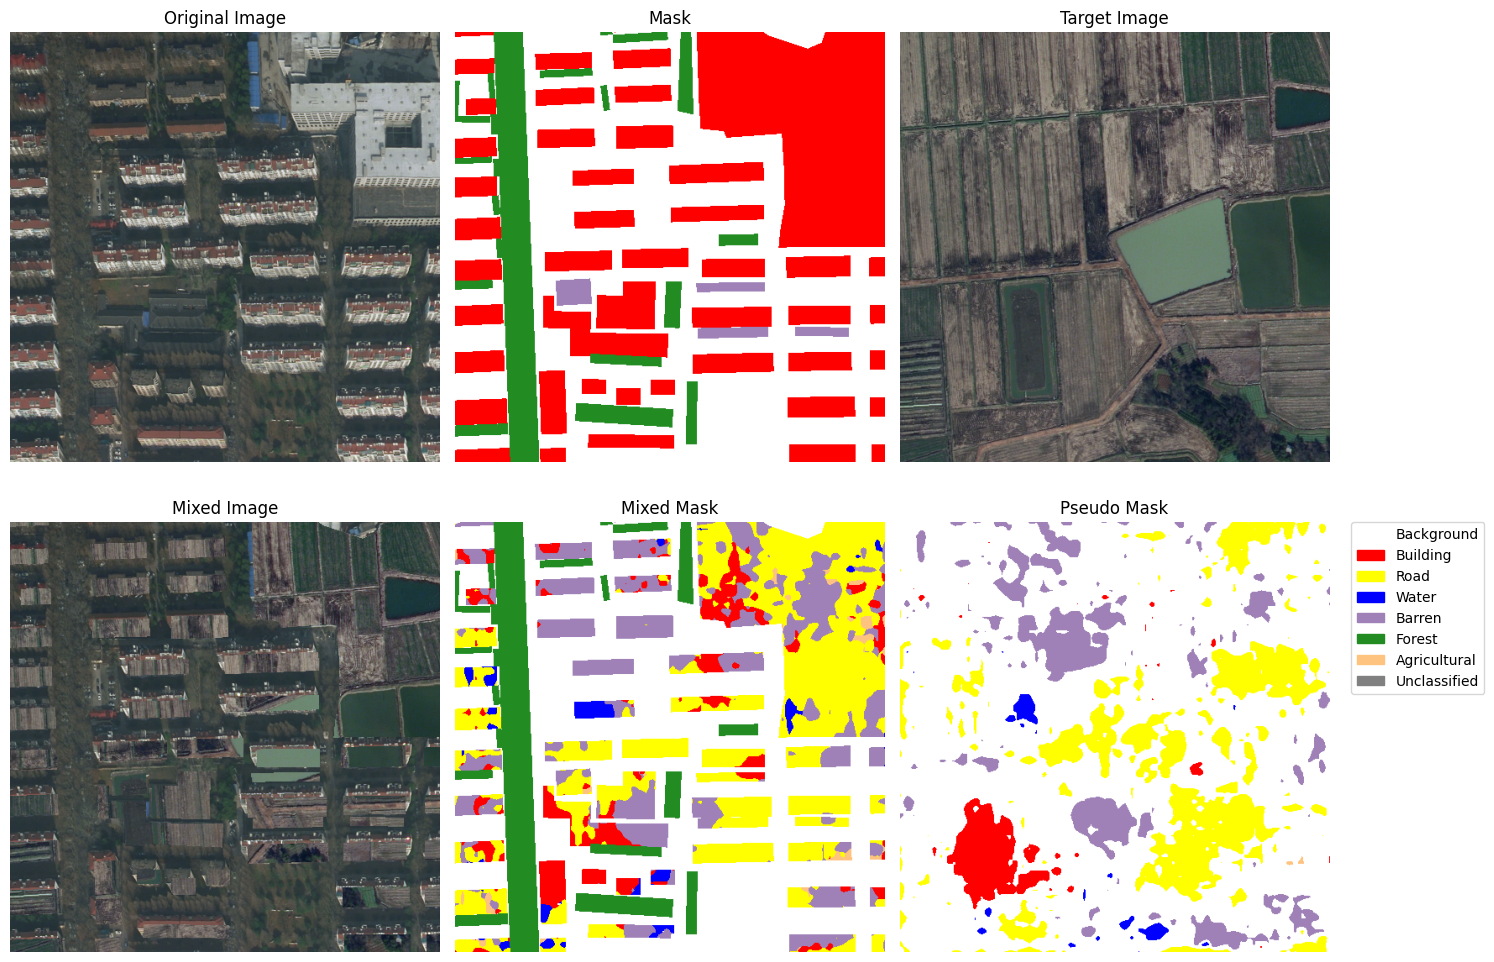

In [ ]:
image = images[0]
image_t = images_t[0]
mixed_image = mixed_images[0]
mask = masks[0]
mixed_mask = mixed_masks[0]
global_threshold = 0.968

# Create a confident mask for all pixels based on the global threshold
confident_mask = max_probs.ge(global_threshold)

# Apply the confident mask to the pseudo_label
pseudo_label = pseudo_label * confident_mask
pseudo_mask = pseudo_label[0]

print(f"Max prob distribution: {max_probs.min()} - {max_probs.max()} - {max_probs.mean()}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.flatten()

axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')

adapted_mask = new_colors_mask(mask.cpu().numpy())
plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
axes[1].imshow(adapted_mask)
axes[1].set_title("Mask")
axes[1].axis('off')

axes[2].imshow(image_t.permute(1, 2, 0).cpu().numpy())
axes[2].set_title("Target Image")
axes[2].axis('off')

axes[3].imshow(mixed_image.permute(1, 2, 0).cpu().numpy())
axes[3].set_title("Mixed Image")
axes[3].axis('off')

adapted_mask_2 = new_colors_mask(mixed_mask.cpu().numpy())
plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
axes[4].imshow(adapted_mask_2)
axes[4].set_title("Mixed Mask")
axes[4].axis('off')

adapted_pseudo_mask = new_colors_mask(pseudo_mask.cpu().numpy())
plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
axes[5].imshow(adapted_pseudo_mask)
axes[5].set_title("Pseudo Mask")
axes[5].axis('off')

plt.tight_layout()
plt.show()

# TEST

In [ ]:
!pip install torchmetrics ptflops

In [ ]:
TEST_ONLY_ON_BEST = True

from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops
import os

DEVICE = 'cuda'
TYPE = 'Test'
# WARNING: YOU MAY DECIDE TO OVVERIDE THE CHOOSE_TRANSFORM, BUT BE CAREFUL. BE SURE THE MODEL YOU'RE USING IS THE CORRECT ONE
CHOOSE_TRANSFORM = 'Resize'

# Create unweighted models
model = get_seg_model(cfg, imgnet_pretrained=False)

# find filenames that start with model_name_pattern using os
model_files_paths = [f for f in os.listdir('.') if f.endswith(".pth")]
print(model_files_paths)

for model_file_path in model_files_paths:
    best_model = torch.load(model_file_path, weights_only=True)
    # best_disc_model = torch.load(disc_model_file_path, weights_only=True)

    model.load_state_dict(best_model)
    model = model.to(DEVICE)
    # disc_model.load_state_dict(best_disc_model)
    # disc_model = disc_model.to(DEVICE)

    accuracy, mIoU = True, True

    TARGETs = ['Urban', 'Rural']

    for TARGET in TARGETs:
        target_type = 'Validation' # 'Validation' or 'ActualTest'

        test_dataset = LoveDADataset(baseTransform=AUGMENTATIONS['Resize512'], augTransforms=None, split=TARGET, type=target_type, useBoundaries=False)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

        #### TEST LOOP
        model.eval()
        print(f"Testing model={model_file_path} on domain={TARGET} on a {target_type} split")

        # Latency
        with torch.no_grad():
            start_time = time.time()
            for _ in range(100):
                _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
            end_time = time.time()
        latency = (end_time - start_time) / 100
        print(f"Latency: {latency:.4f} seconds")

        # FLOPs
        macs, _ = ptflops.get_model_complexity_info(model,
            (3, RESIZE, RESIZE), as_strings=False,
            print_per_layer_stat=False, verbose=False)
        flops = macs * 2  # MACs perform two FLOPs
        print("FLOPs:", flops)

        # Number of parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")

        if TYPE == 'Test':
            with torch.no_grad():
                total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
                total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
                meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
                for (batch) in tqdm(test_loader):
                    ### Extract input
                    images, masks, img_path, bd_gts = batch
                    images = images.float().to(DEVICE)
                    masks = masks.to(DEVICE)

                    ### ===> Forward, Upscale, Compute Losses
                    ## Forward
                    outputs = model(images)

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    # Output 1 is the prediction

                    # Shape: NBATCHES x classes x h x w
                    class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

                    if accuracy:
                    # Create a mask for valid targets (where target is not -1)
                        valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
                        # Apply the mask to ignore -1 targets when updating the accuracy metric
                        meter.update(class_indices[valid_mask], masks[valid_mask])

                    if mIoU:
                        for predicted, target in zip(class_indices, masks):
                            for i in range(NUM_CLASSES):
                                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

        if accuracy:
            accuracy = meter.compute()
            print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

        if mIoU:
            intersection_over_union = total_intersection / total_union

            # Per class IoU
            for i, iou in enumerate(intersection_over_union):
                class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
                print(f'{class_name} IoU: {iou:.4f}')

            mIoU = torch.mean(intersection_over_union)
            print(f'\nmIoU on the {TARGET} domain: {mIoU}')

        print("========================================================================")


<ipython-input-174-c45f6e9ccf7a>:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')


['best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth', 'best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_17.pth', 'best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_19.pth', 'best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_20.pth', 'best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_18.pth']
Dataset size: 232
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth on domain=Urban on a Validation split
Latency: 0.0360 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:13<00:00,  4.42s/it]



Accuracy on the target domain: 67.07%
Background IoU: 0.5019
Building IoU: 0.5103
Road IoU: 0.5367
Water IoU: 0.7346
Barren IoU: 0.3765
Forest IoU: 0.3603
Agricultural IoU: 0.0700

mIoU on the Urban domain: 0.4414595365524292
Dataset size: 274
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth on domain=Rural on a Validation split
Latency: 0.0618 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 4/4 [00:16<00:00,  4.04s/it]



Accuracy on the target domain: 39.34%
Background IoU: 0.2723
Building IoU: 0.2751
Road IoU: 0.2690
Water IoU: 0.4770
Barren IoU: 0.1111
Forest IoU: 0.3445
Agricultural IoU: 0.0234

mIoU on the Rural domain: 0.25321048498153687
Dataset size: 232
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_17.pth on domain=Urban on a Validation split
Latency: 0.0267 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:13<00:00,  4.52s/it]



Accuracy on the target domain: 68.47%
Background IoU: 0.5246
Building IoU: 0.5158
Road IoU: 0.5173
Water IoU: 0.6570
Barren IoU: 0.4150
Forest IoU: 0.3457
Agricultural IoU: 0.4681

mIoU on the Urban domain: 0.49192649126052856
Dataset size: 274
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_17.pth on domain=Rural on a Validation split
Latency: 0.0270 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 4/4 [00:16<00:00,  4.25s/it]



Accuracy on the target domain: 33.92%
Background IoU: 0.2666
Building IoU: 0.2271
Road IoU: 0.1666
Water IoU: 0.4492
Barren IoU: 0.1162
Forest IoU: 0.0641
Agricultural IoU: 0.1200

mIoU on the Rural domain: 0.20138713717460632
Dataset size: 232
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_19.pth on domain=Urban on a Validation split
Latency: 0.0256 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:14<00:00,  4.78s/it]



Accuracy on the target domain: 69.29%
Background IoU: 0.5338
Building IoU: 0.5095
Road IoU: 0.5108
Water IoU: 0.6812
Barren IoU: 0.4285
Forest IoU: 0.4215
Agricultural IoU: 0.3866

mIoU on the Urban domain: 0.49598395824432373
Dataset size: 274
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_19.pth on domain=Rural on a Validation split
Latency: 0.0301 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 4/4 [00:16<00:00,  4.04s/it]



Accuracy on the target domain: 33.93%
Background IoU: 0.2675
Building IoU: 0.1997
Road IoU: 0.1558
Water IoU: 0.4769
Barren IoU: 0.1114
Forest IoU: 0.1171
Agricultural IoU: 0.0809

mIoU on the Rural domain: 0.20131856203079224
Dataset size: 232
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_20.pth on domain=Urban on a Validation split
Latency: 0.0266 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]



Accuracy on the target domain: 69.71%
Background IoU: 0.5314
Building IoU: 0.5085
Road IoU: 0.5451
Water IoU: 0.7519
Barren IoU: 0.4321
Forest IoU: 0.4133
Agricultural IoU: 0.3403

mIoU on the Urban domain: 0.503233790397644
Dataset size: 274
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_20.pth on domain=Rural on a Validation split
Latency: 0.0263 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 4/4 [00:16<00:00,  4.10s/it]



Accuracy on the target domain: 31.75%
Background IoU: 0.2585
Building IoU: 0.1908
Road IoU: 0.1827
Water IoU: 0.4941
Barren IoU: 0.0792
Forest IoU: 0.0901
Agricultural IoU: 0.0346

mIoU on the Rural domain: 0.19001537561416626
Dataset size: 232
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_18.pth on domain=Urban on a Validation split
Latency: 0.0265 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:14<00:00,  4.86s/it]



Accuracy on the target domain: 69.55%
Background IoU: 0.5361
Building IoU: 0.5138
Road IoU: 0.4884
Water IoU: 0.7935
Barren IoU: 0.4172
Forest IoU: 0.4021
Agricultural IoU: 0.4282

mIoU on the Urban domain: 0.5113356113433838
Dataset size: 274
Testing model=best_DACS_model_Resize512__PRETRN=False__LAMBDA_MIXED=1__LR=0.0008_LRstep=14.pth_18.pth on domain=Rural on a Validation split
Latency: 0.0259 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


Accuracy on the target domain: 33.56%
Background IoU: 0.2614
Building IoU: 0.2435
Road IoU: 0.1467
Water IoU: 0.4817
Barren IoU: 0.1043
Forest IoU: 0.0911
Agricultural IoU: 0.1029

mIoU on the Rural domain: 0.20452789962291718
